In [ ]:
#1 Import Libraries
#2 Import dataset 
#3 Explore dataset and visulize 
#4 Feature Engineering 
#5 Divide Features and target for input 
#6 Split dataset to Train and test
#7 Choose and Train a model 
#8 Check RSMLE 
#9 Repeat step 7 to get good results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
import time
import xgboost as xgb 
import numpy as np

In [2]:
# importing calories data as pandas DataFrame
calories_df = pd.read_csv('train.csv')
# Exploring the dataframe 
calories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


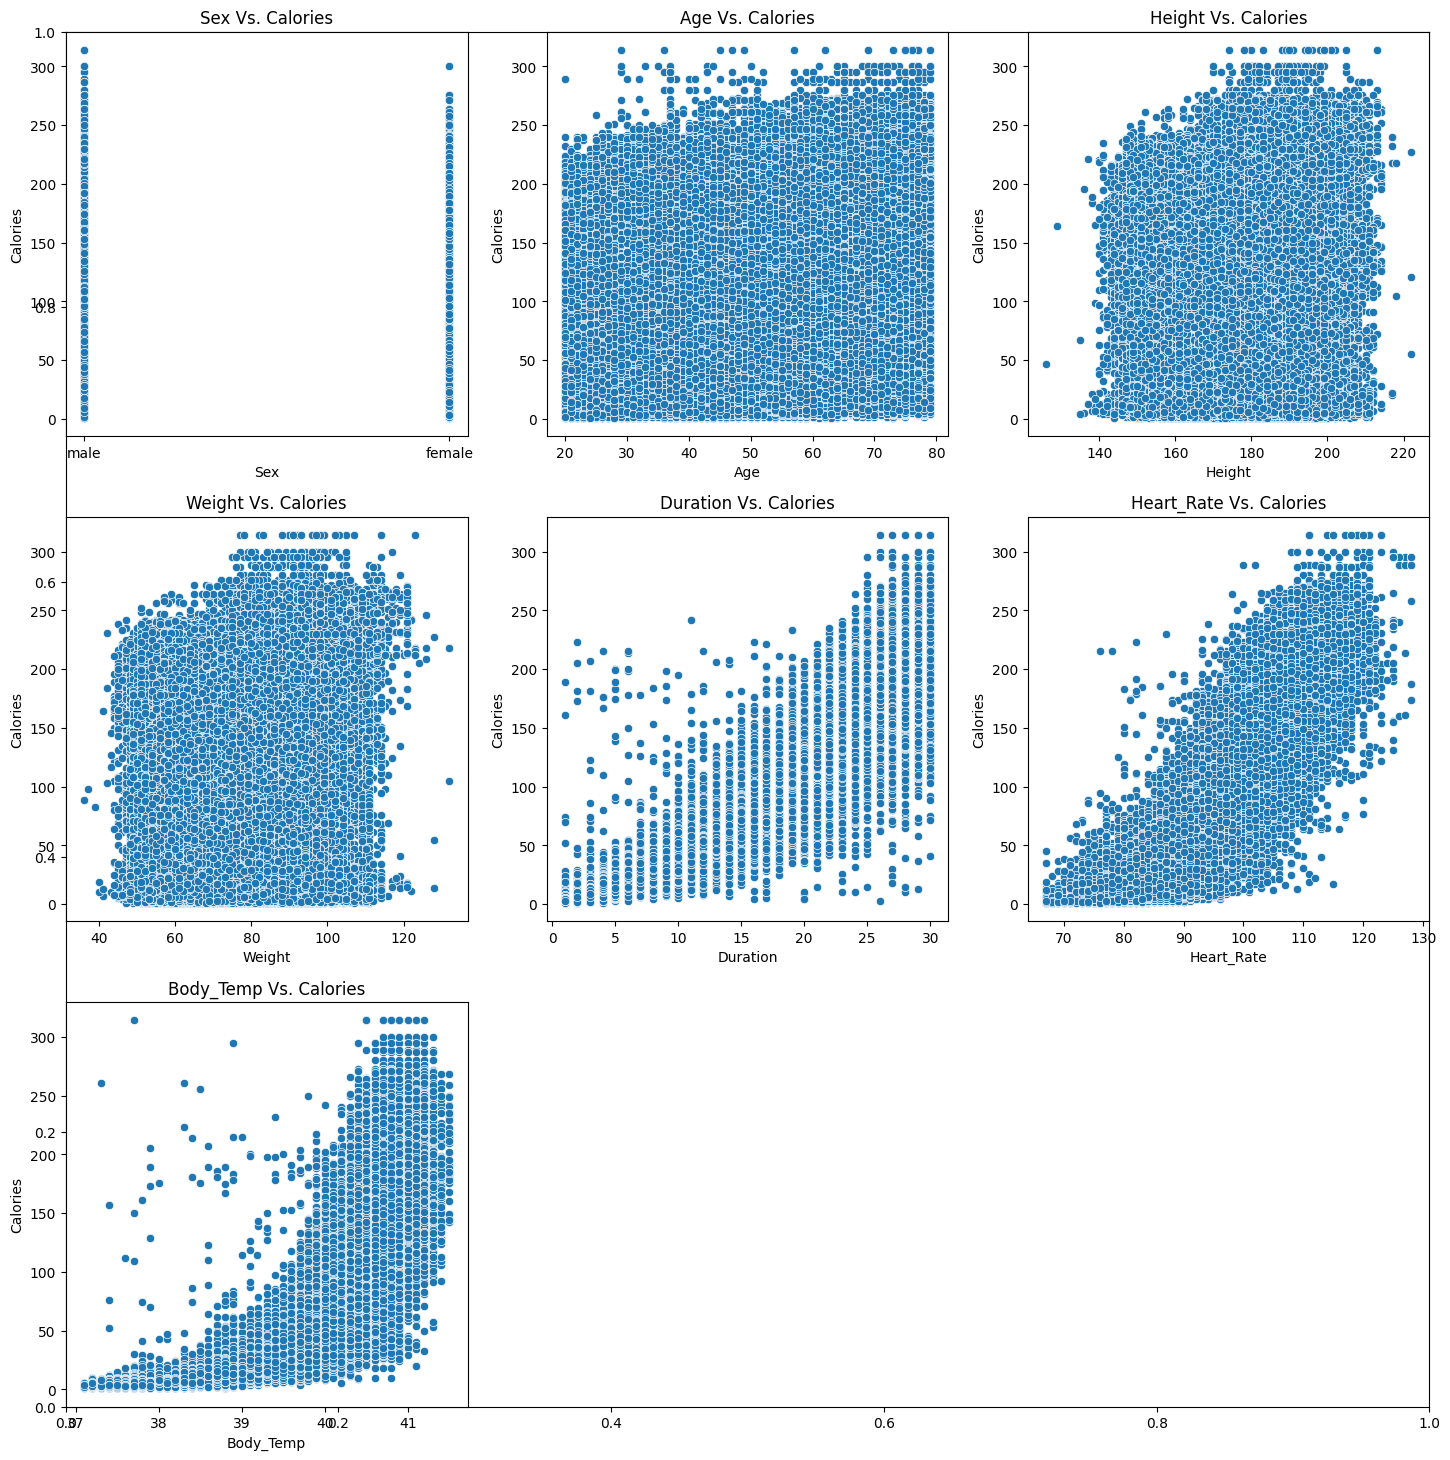

In [3]:
# Visulize the dataset and draw intuition 

# Figure size for the sub plots 
plt.subplots(figsize=(15, 15))

# List of columns to visulize
columns_to_visulize = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

# Loop through the columns to visulize 
for i, col in enumerate(columns_to_visulize):
    plt.subplot(3, 3, i+1)

    # Scatter plot
    sns.scatterplot(x=calories_df[col], y=calories_df['Calories'])
    plt.title(f"{col} Vs. Calories")

plt.tight_layout()
plt.show()

<Axes: >

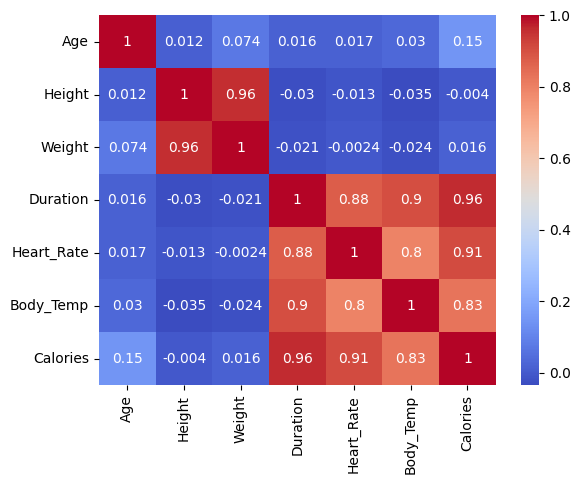

In [5]:
# Drawing correlation map of feature to more understand 
calories_df_new = calories_df.drop(columns=['Sex', 'id'])
corr = calories_df_new.corr()
sns.heatmap(corr, cmap="coolwarm", annot=True)

In [6]:
# As seen the important feature are Body_Temp,  Heart_Rate, Duration, Weight and Age so we are going to create a new feature for intensity 
# Intensity = Heart_Rate / Max_Heart_Rate where Max_Heart_Rate = 220 - Age

# Calculating Maximum Heart Rate and adding it to Feature 
calories_df_new['Max_Heart_Rate'] = 220 - calories_df_new['Age']

# Step 2: Compute Intensity as a percentage of Max Heart Rate
calories_df_new['Intensity'] = (calories_df_new['Heart_Rate'] / calories_df_new['Max_Heart_Rate']) * 100



In [8]:
X = calories_df_new.drop(columns=['Calories', 'Max_Heart_Rate'])
y = calories_df_new['Calories']

# Splitting model to Train and Test dataset 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [15]:
# Training XGBoost Regressor model

# Start the timer
start_time = time.time()

# Defining XGBoost Regress model with Parameters
model = xgb.XGBRegressor(
    n_estimators=3000, #100
    learning_rate=0.01, #0.06 RMSLE: 0.0744 #0.09 RMSLE: 0.0692 
    max_depth=8, #12
    eval_metric="rmse",
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=0.1,
    random_state=42
)

model.fit(X_train, y_train)

# Ending time
end_time = time.time()

# Calculating Time elapsed 
elapsed_time = end_time - start_time

print(f"Training time: {elapsed_time:.2f} seconds")

Training time: 20.78 seconds


In [16]:
# Prediction 
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))

print(f"RMSE: {rmse:.4f}")
print(f"RMSLE: {rmsle:.4f}")

RMSE: 4.1027
RMSLE: 0.0689


In [1]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Calories")
plt.xlabel("Predicted Calories")
plt.title("Actual Vs. Predicte Calories")
plt.grid(True)
plt.show()


NameError: name 'plt' is not defined

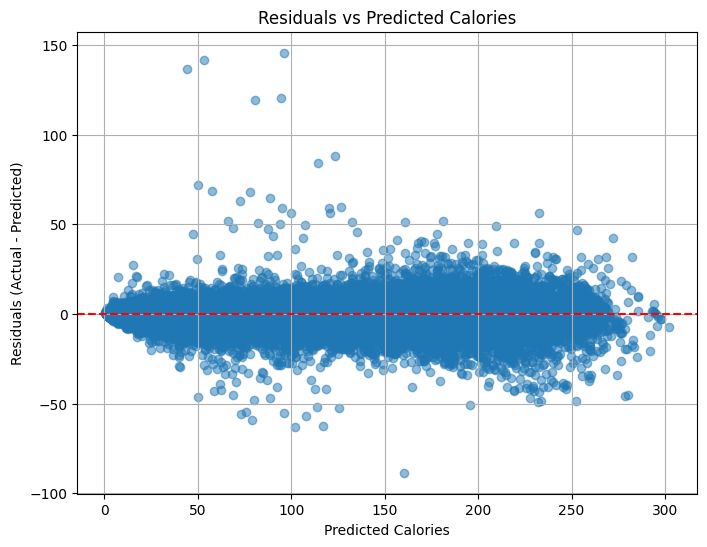

In [18]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Calories")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Calories")
plt.grid(True)
plt.show()


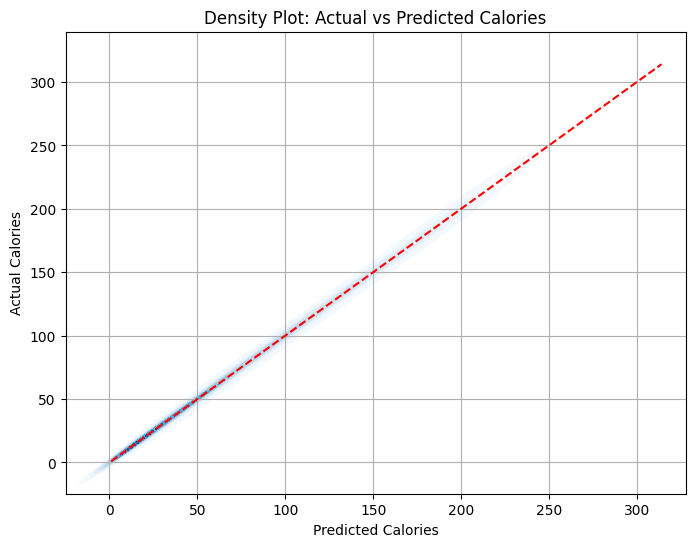

In [19]:


plt.figure(figsize=(8, 6))
sns.kdeplot(x=y_pred, y=y_test, cmap="Blues", fill=True, thresh=0.05)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Predicted Calories")
plt.ylabel("Actual Calories")
plt.title("Density Plot: Actual vs Predicted Calories")
plt.grid(True)
plt.show()


In [70]:
# loading new test set 
test = pd.read_csv('test.csv')

# Preparing new test dataset with same feautre that were used in training 
# Calculating Maximum Heart Rate and adding it to Feature 
test['Max_Heart_Rate'] = 220 - calories_df_new['Age']

# Step 2: Compute Intensity as a percentage of Max Heart Rate
test['Intensity'] = (calories_df_new['Heart_Rate'] / calories_df_new['Max_Heart_Rate']) * 100

# Final New test dataset 
columns_to_drop = ['id', 'Sex', 'Max_Heart_Rate']
test_new = test.drop(columns=columns_to_drop)

In [73]:
# Making prediction on new test set and saving predictions

y_pred_new = model.predict(test_new)
y_pred_new_clipped = np.maximum(0, y_pred_new) # Clippling the values to avoid negatives 

# Saving new predicted values
submission = pd.DataFrame({ 'id': test['id'],
                            'Calories': y_pred_new_clipped})
submission.to_csv('./submission.csv', index=False)

In [74]:
submission.head

<bound method NDFrame.head of             id    Calories
0       750000   32.411583
1       750001  114.682449
2       750002   72.010735
3       750003  108.032677
4       750004   82.860680
...        ...         ...
249995  999995   24.813725
249996  999996   22.651175
249997  999997   78.806206
249998  999998  144.595398
249999  999999   84.757080

[250000 rows x 2 columns]>

In [20]:
from lightgbm import LGBMRegressor


In [21]:
lgb_model = LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    colsample_bytree=0.7,
    objective='regression',
    random_state=42
)

# 2. Fit the model
lgb_model.fit(X_train, y_train)

# 3. Predict on test data
y_pred_lgb = lgb_model.predict(X_test)

# 4. Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred_lgb))

print(f"LGBM RMSE: {rmse:.4f}")
print(f"LGBM RMSLE: {rmsle:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 7
[LightGBM] [Info] Start training from score 88.298465
LGBM RMSE: 4.1384
LGBM RMSLE: 0.0703


In [22]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.01,
    depth=12,
    l2_leaf_reg=4,
    verbose=0,
    random_state=42
)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)

cat_rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred_cat))
print(f"CatBoost RMSLE: {cat_rmsle:.4f}")

CatBoost RMSLE: 0.0689


In [23]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=2000, random_state=42)
mlp.fit(X_train, y_train)

# Predict and evaluate
y_pred = mlp.predict(X_test)
y_pred_clipped = np.maximum(0, y_pred)  # avoid negatives

rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred_clipped))
print(f"RMSLE (Neural Network): {rmsle:.4f}")

RMSLE (Neural Network): 0.0736


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
# Define base models
estimators = [
    ('xgb', model),   # already trained or define here
    ('lgb', lgb_model),
    ('cat', cat_model)
]

# Define stacking model with Ridge or any meta-learner
stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(),
    n_jobs=-1
)

# Fit stack model
stack_model.fit(X_train, y_train)

# Predict
y_pred_stack = stack_model.predict(X_test)

# Evaluate
stack_rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred_stack))
print(f"Stacked Model RMSLE: {stack_rmsle:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 7
[LightGBM] [Info] Start training from score 88.314250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 7
[LightGBM] [Info] 